# Fast AI Course - Lesson 10 homework

This is the notebook used to build this [HuggingFace Space](https://huggingface.co/spaces/mattb512/fastai-lesson-10-diffusers)

* Generate image with text input, image input and negative prompt. 
* Capture latents during generation.

![alt text](./ai-math.png "a cute dog mixed with a bird")

In [2]:
# useful links
# hf source code
# sd:      https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/text2img#diffusers.StableDiffusionPipeline
# img2img: https://github.com/huggingface/diffusers/blob/fee93c81eb7c5e9fe1618f858f1e369567170edc/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py#L90

# notebooks
# https://forums.fast.ai/t/implementing-stable-diffusion-from-its-components/105423?replies_to_post_number=3
# https://forbo7.github.io/forblog/posts/13_implementing_stable_diffusion_from_its_components.html#create-latents

In [ ]:
!pip install -Uq ipywidgets diffusers transformers fastcore matplotlib scipy

In [ ]:
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

# all in one

In [5]:
# copy of image_generator.py

import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image
import numpy as np
# from IPython.display import display
from torchvision import transforms as tfms

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm


logging.disable(logging.WARNING)
class ImageGenerator():
    def __init__(self):
        self.latent_images = []
        self.width = 512
        self.height = 512
        self.generator = torch.manual_seed(32)
        self.bs = 1
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
            self.float_size = torch.float16
        elif torch.backends.mps.is_available():
            self.device = torch.device("mps")
            self.float_size = torch.float32
        else:
            if not torch.backends.mps.is_built():
                print("MPS not available because the current PyTorch install was not "
                    "built with MPS enabled.")
            else:
                print("MPS not available because the current MacOS version is not 12.3+ "
                    "and/or you do not have an MPS-enabled device on this machine.")
            self.device = torch.device("cpu")
            self.float_size = torch.float32
        
        print(f"pytorch device: {self.device}")

    def __repr__(self):
        return f"Image Generator with {self.width=} {self.height=}"

    def load_models(self):
        self.tokenizer    = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=self.float_size)
        self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=self.float_size).to( self.device)
        # vae             = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema",             torch_dtype=torch.float16                          ).to(self.device)
        self.vae          = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4",   subfolder="vae").to( self.device)
        self.unet         = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet" ).to( self.device) #torch_dtype=torch.float16,

    def load_scheduler( self,               
                        beta_start : float=0.00085,
                        beta_end : float=0.012, 
                        num_train_timesteps :int=1000):

        self.scheduler = LMSDiscreteScheduler(
            beta_start=beta_start,
            beta_end=beta_end,
            beta_schedule="scaled_linear",
            num_train_timesteps=num_train_timesteps)

    def load_image(self, filepath:str):
        return Image.open(filepath).resize(size=(self.width,self.height)) 
        #.convert("RGB") # RGB = 3 dimensions, RGBA = 4 dimensions

    def pil_to_latent(self, image: Image) -> torch.Tensor:
        with torch.no_grad():
            image = image.resize(size=(self.width,self.height)) 
            np_img = np.transpose( (( np.array(image) / 255)-0.5)*2, (2,0,1)) # turn pil image into np array with values between -1 and 1
            # print(f"{np_img.shape=}") # 4, 64, 64
            
            np_images = np.repeat(np_img[np.newaxis, :, :], self.bs, axis=0).astype(np.float32) # adding a new dimension and repeating the image for each prompt, float32 required for mac
            # print(f"{np_images.shape=}")
            
            decoded_latent = torch.from_numpy(np_images).to(self.device).float() #<-- stability-ai vae uses half(), compvis vae uses float?
            # print(f"{decoded_latent.shape=}")
            
            encoded_latent = 0.18215 * self.vae.encode(decoded_latent).latent_dist.sample()
            # print(f"{encoded_latent.shape=}")
    
            return encoded_latent

    def add_noise(self, latent: torch.Tensor, scheduler_steps: int = 10) -> torch.FloatTensor:
        # noise = torch.randn_like(latent) # missing generator parameter
        noise = torch.randn(
                size = (self.bs, self.unet.config.in_channels, self.height//8, self.width//8),
                generator = self.generator).to(self.device)
        timesteps = torch.tensor([self.scheduler.timesteps[scheduler_steps]])
        noisy_latent = self.scheduler.add_noise(latent, noise, timesteps)
        # print(f"add_noise: {timesteps.shape=} {timesteps=} {noisy_latent.shape=}")
        return noisy_latent

    def latent_to_pil(self, latent:torch.Tensor) -> Image:
        # print(f"latent_to_pil {latent.dtype=}")
        with torch.no_grad():
            decoded = self.vae.decode(1 / 0.18215 * latent).sample[0]
        # print(f"latent_to_pil {decoded.shape=}")
        image = (decoded/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
        return Image.fromarray((image*255).round().astype("uint8"))    

    def image_grid(self, imgs: [Image]) -> Image:
        print(len(imgs))
        w,h = imgs[0].size
        cols = len(imgs)
        grid = Image.new('RGB', size=(cols*w, h))
        for i, img in enumerate(imgs): 
            # print(f"{img.size=}")
            grid.paste(img, box=(i%cols*w, i//cols*h))
        return grid        

    def text_enc(self, prompt:str, maxlen=None) -> torch.Tensor:
        '''tokenize and encode a prompt'''
        if maxlen is None: maxlen = self.tokenizer.model_max_length
        
        inp = self.tokenizer([prompt], padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
        return self.text_encoder(inp.input_ids.to(self.device))[0].float()

    def tensor_to_pil(self, t:torch.Tensor) -> Image:
        '''transforms a tensor decoded by the vae to a pil image'''
        # print(f"tensor_to_pil {t.shape=} {type(t)=}")
        image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
        return Image.fromarray((image*255).round().astype("uint8"))

    def latent_callback(self, latent:torch.Tensor) -> None:
        '''store latents in an array so that we can inpect them later.'''
        with torch.no_grad():
            # print(f"cb {latent.shape=}")
            decoded = self.vae.decode(1 / 0.18215 * latent).sample[0]
            self.latent_images.append(self.tensor_to_pil(decoded))

    def generate(self, 
                 prompt : str="",
                 secondary_prompt: str=None,
                 prompt_mix_ratio : float=0.5,                 
                 negative_prompt="", 
                 seed : int=32, 
                 guidance :float=7.5,
                 steps : int=30,
                 start_step_ratio : float=1/5,
                 init_image : Image=None, 
                 latent_callback_mod : int=10,
                 progress_tqdm: callable=tqdm):
        self.latent_images = []
        if not negative_prompt: negative_prompt = ""
        print(f"ImageGenerator: {prompt=} {secondary_prompt=} {prompt_mix_ratio=} {negative_prompt=} {guidance=} {steps=} {init_image=} ") 
        
        with torch.no_grad():
            text = self.text_enc(prompt)
            if secondary_prompt:
                print("using secondary prompt")
                sec_prompt_text = self.text_enc(secondary_prompt)
                text = text * prompt_mix_ratio  + sec_prompt_text * ( 1 - prompt_mix_ratio )
            uncond = self.text_enc(negative_prompt * self.bs, text.shape[1])
        emb = torch.cat([uncond, text])
        if seed: torch.manual_seed(seed)
    
        self.scheduler.set_timesteps(steps)
        self.scheduler.timesteps = self.scheduler.timesteps.to(torch.float32)
    
        if (init_image == None):
            start_steps = 0
            latents = torch.randn(
                size = (self.bs, self.unet.config.in_channels, self.height//8, self.width//8),
                generator = self.generator)
            latents = latents * self.scheduler.init_noise_sigma
            # print(f"{latents.shape=}")
        else:
            print("using base image")
            start_steps = int(steps * start_step_ratio) # 0%: too much noise, 100% no noise
            # print(f"{start_steps=}")
            latents =self.pil_to_latent(init_image)
            self.latent_callback(latents)
            latents = self.add_noise(latents, start_steps).to(self.device).float()
            self.latent_callback(latents)

        latents = latents.to(self.device).float() 

        for i,ts in enumerate(progress_tqdm(self.scheduler.timesteps, desc="Latent Generation")): #leave=False, does not work with gradio
            if i >= start_steps:
                inp = self.scheduler.scale_model_input(torch.cat([latents] * 2), ts)
                with torch.no_grad(): 
                    u,t = self.unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2) #todo, grab those with callbacks
                pred = u + guidance*(t-u)
                # pred = u + self.g*(t-u)/torch.norm(t-u)*torch.norm(u)
                latents = self.scheduler.step(pred, ts, latents).prev_sample
    
                if latent_callback_mod and i % latent_callback_mod == 0: 
                    self.latent_callback(latents)

        return self.latent_to_pil(latents), self.latent_images

# instantiate object

In [6]:
ig = ImageGenerator()
print(ig)

pytorch device: mps
Image Generator with self.width=512 self.height=512


In [7]:
ig.load_models()

In [8]:
ig.load_scheduler()

# test auto-encoder

In [19]:
init_image = "macaw.jpg"

# loading init image
init_image_pil = ig.load_image(init_image)

# encoding to latent and decoding it back
latent = ig.pil_to_latent(init_image_pil)
img2 = ig.latent_to_pil(latent)

2


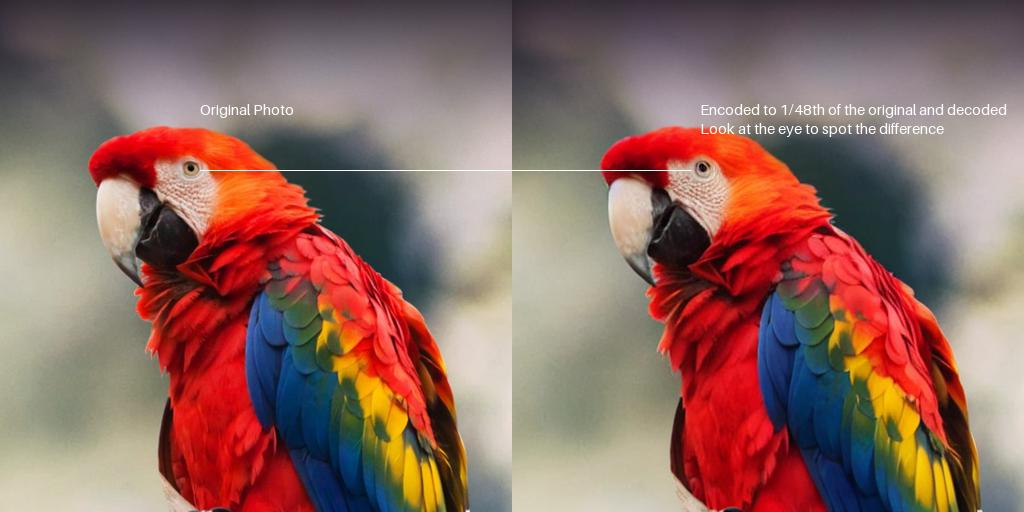

In [42]:
#| code-fold: true
#| echo: false
from PIL import ImageDraw, ImageFont
pil_image = ig.image_grid([init_image_pil, img2])
draw = ImageDraw.Draw(pil_image); draw.line((200, 170, 690, 170)); 
font = ImageFont.load_default(size=15); draw.text((200, 100),"Original Photo",(255,255,255), font=font); draw.text((700, 100),"Encoded to 1/48th of the original and decoded\nLook at the eye to spot the difference",(255,255,255), font=font)
pil_image


# simple prompt

In [15]:
generated_image, latents = ig.generate(
    prompt="a cute puppy",
    secondary_prompt=None,
    prompt_mix_ratio=None,    
    negative_prompt=None,
    guidance=7.5,
    steps=30,
    init_image=None, 
    latent_callback_mod=None )


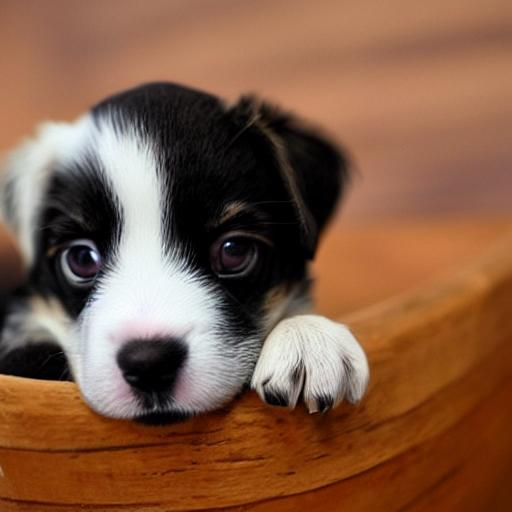

In [16]:
generated_image

# trying different guidance values

In [ ]:
guidance_test_bank = []

for r in np.linspace(0, 14, 10):
    generated_image, latents = ig.generate(
        prompt="a cute puppy",
        secondary_prompt=None,
        prompt_mix_ratio=None,
        negative_prompt=None,
        guidance=r,
        steps=50,
        start_step_ratio=None,
        init_image=None, 
        latent_callback_mod=None )
    guidance_test_bank.append(generated_image)


10


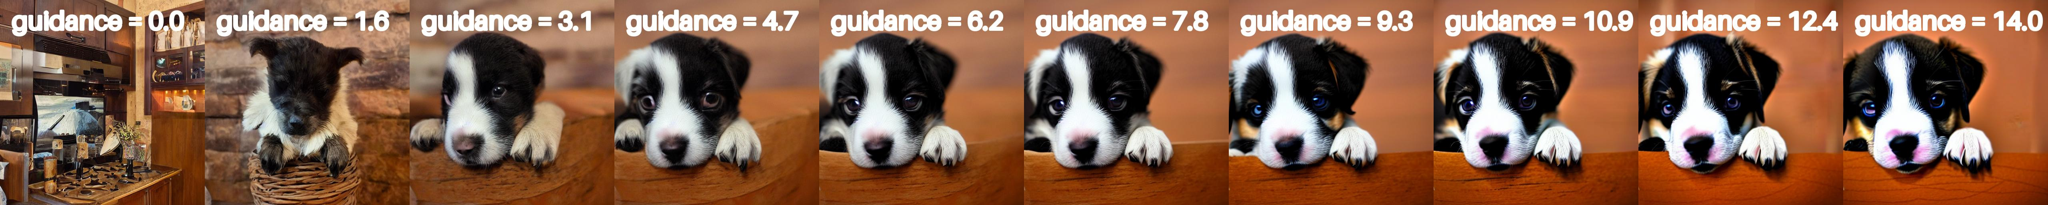

In [40]:
#| code-fold: true
#| echo: false
img = ig.image_grid(guidance_test_bank)
draw = ImageDraw.Draw(img);
font = ImageFont.load_default(size=65)
for i, r in enumerate(np.linspace(0, 14, 10)):
    draw.text(xy=(30 + i*512, 10), text=f"guidance = {r:.1f}",fill=(255,255,255), font=font, stroke_width=3); #, stroke_fill="grey"
img

# with negative prompt

In [ ]:
tree_img, _ = ig.generate(
    prompt="a beautiful tree",
    secondary_prompt=None,
    prompt_mix_ratio=None,    
    negative_prompt=None,
    guidance=7.5,
    steps=50,
    init_image=None, 
    latent_callback_mod=None )

tree_img_2, _ = ig.generate(
    prompt="a beautiful tree",
    secondary_prompt=None,
    prompt_mix_ratio=None,    
    negative_prompt="green",
    guidance=7.5,
    steps=50,
    init_image=None, 
    latent_callback_mod=None )


2


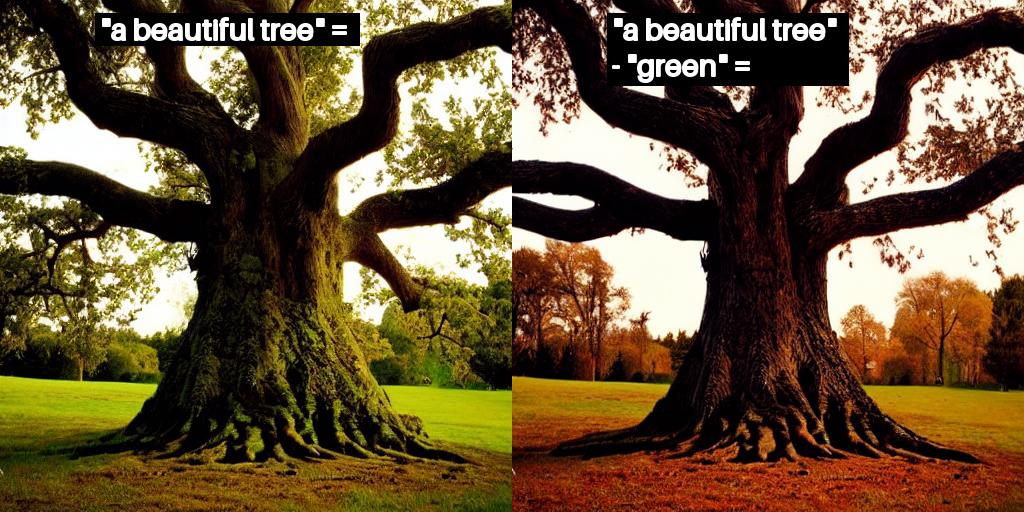

In [39]:
#| code-fold: true
#| echo: false
img = ig.image_grid([tree_img, tree_img_2])
draw = ImageDraw.Draw(img);font = ImageFont.load_default(size=30)
left, top, right, bottom = draw.textbbox((100, 10), "\"a beautiful tree\" = ", font=font)
draw.rectangle((left-5, top-5, right+5, bottom+5), fill="black")
draw.text(xy=(100, 10), text=f"\"a beautiful tree\" =",fill=(255,255,255), font=font, stroke_width=1);

left, top, right, bottom = draw.textbbox((100 + 512, 10), "\"a beautiful tree\" \n- \"green\"", font=font)
draw.rectangle((left-5, top-5, right+5, bottom+5), fill="black")
draw.text(xy=(100 + 512, 10), text=f"\"a beautiful tree\" \n- \"green\" =",fill=(255,255,255), font=font, stroke_width=1);
img

# mixing prompt embeddings

In [ ]:
start_step_test_bank = []

for r in np.linspace(0, 1, 10):
    generated_image, latents = ig.generate(
        prompt="a cute puppy",
        secondary_prompt="a cute kitty",
        prompt_mix_ratio=r,
        negative_prompt=None,
        guidance=7.5,
        steps=50,
        start_step_ratio=None,
        init_image=None, 
        latent_callback_mod=None )
    start_step_test_bank.append(generated_image)


10


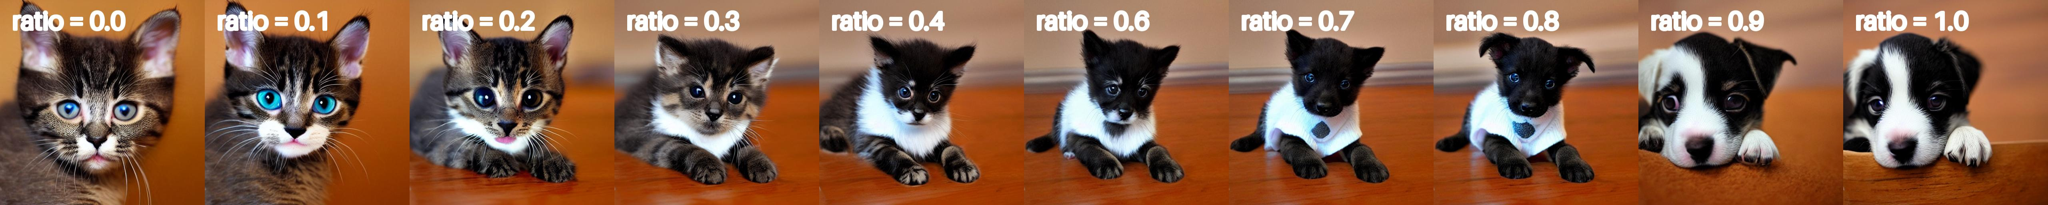

In [95]:
#| code-fold: true
#| echo: false
img = ig.image_grid(start_step_test_bank)
draw = ImageDraw.Draw(img);
font = ImageFont.load_default(size=65)
for i, r in enumerate(np.linspace(0, 1, 10)):
    draw.text(xy=(30 + i*512, 10), text=f"ratio = {r:.1f}",fill=(255,255,255), font=font, stroke_width=3); #, stroke_fill="grey"
img

# with input image

In [ ]:
generated_image, latents = ig.generate(
    prompt="a cute puppy",
    secondary_prompt=None,
    prompt_mix_ratio=None,    
    negative_prompt=None,
    guidance=7.5,
    steps=50,
    start_step_ratio=1/5,
    init_image=init_image_pil, 
    latent_callback_mod=1 )

3


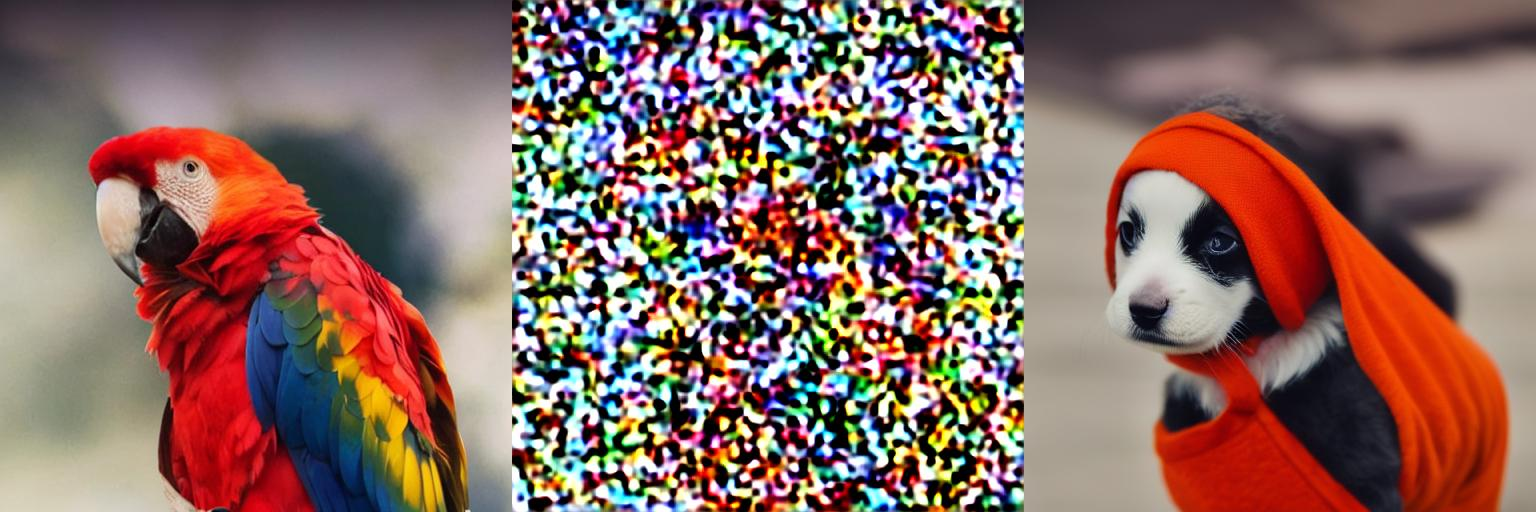

In [103]:
# init image, init image with added noise, image output
ig.image_grid([latents[0], latents[1], generated_image])

18


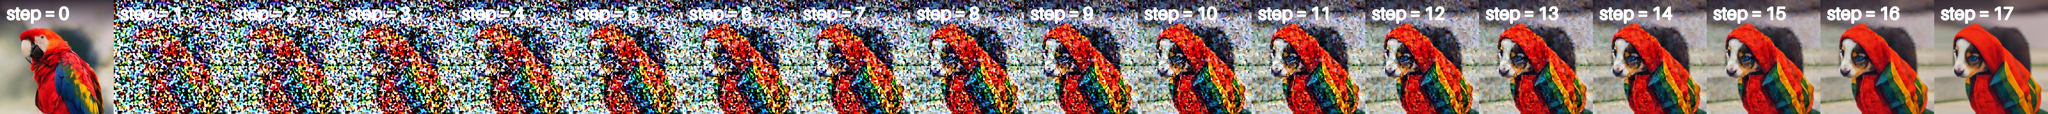

In [109]:
#| code-fold: true
#| echo: false
img = ig.image_grid(latents)
draw = ImageDraw.Draw(img); font = ImageFont.load_default(size=80)
for i, r in enumerate(latents):
    draw.text(xy=(30 + i*512, 10), text=f"step = {i}",fill=(255,255,255), font=font, stroke_width=3); #, stroke_fill="grey"
img

In [ ]:
start_step_test_bank = []
noisy_init_image_bank = []

for r in np.linspace(0.15, 0.35, 10):
    generated_image, latents = ig.generate(
        prompt="a cute puppy",
        secondary_prompt=None,
        prompt_mix_ratio=None,
        negative_prompt=None,
        guidance=7.5,
        steps=50,
        start_step_ratio=r, # too low -> just take the prompt, too high -> just look like the init image
        init_image=init_image_pil, 
        latent_callback_mod=2 )
    start_step_test_bank.append(generated_image)
    noisy_init_image_bank.append(latents[1])

10


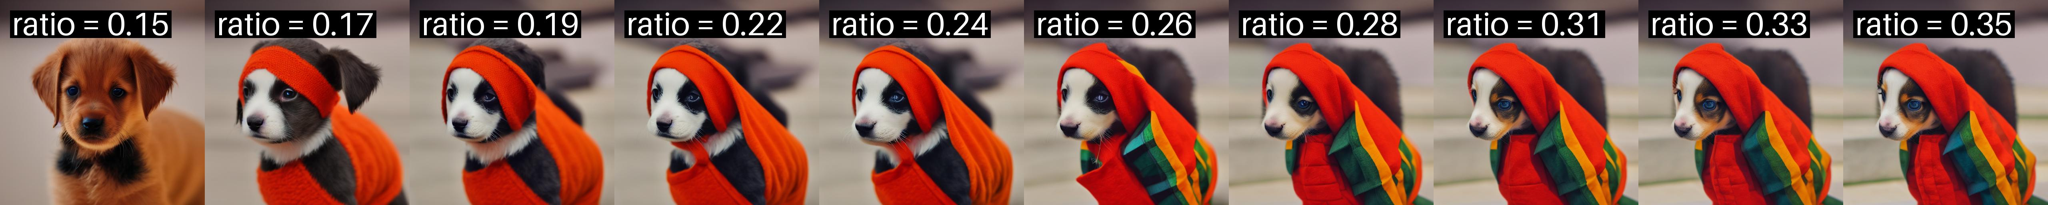

In [124]:
#| code-fold: true
#| echo: false
img = ig.image_grid(start_step_test_bank)
draw = ImageDraw.Draw(img); font = ImageFont.load_default(size=80)
for i, r in enumerate(np.linspace(0.15, 0.35, 10)):
    left, top, right, bottom = draw.textbbox((30 + i*512, 10), f"ratio = {r:0.2f}", font=font)
    draw.rectangle((left-5, top-5, right+5, bottom+5), fill="black")
    draw.text((30 + i*512, 10), f"ratio = {r:0.2f}", font=font, fill="white")
img

10


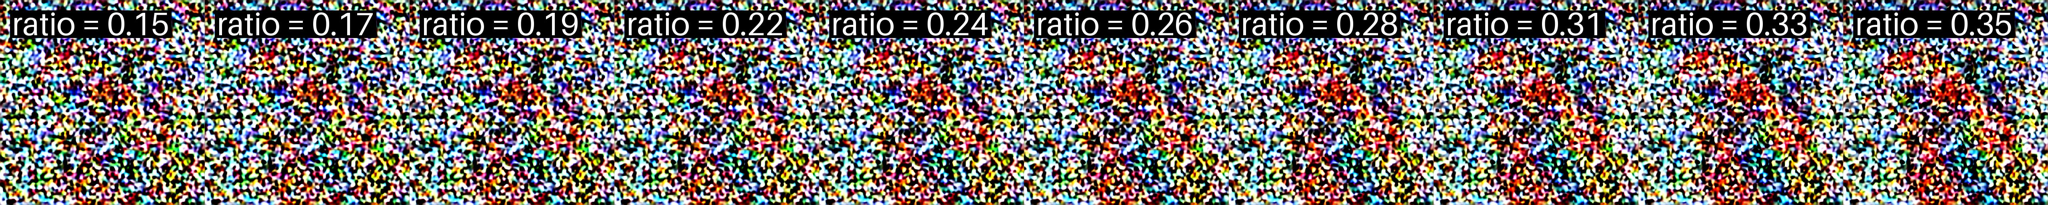

In [123]:
#| code-fold: true
#| echo: false
img = ig.image_grid(noisy_init_image_bank)
draw = ImageDraw.Draw(img); font = ImageFont.load_default(size=80)
for i, r in enumerate(np.linspace(0.15, 0.35, 10)):
    left, top, right, bottom = draw.textbbox((30 + i*512, 10), f"ratio = {r:0.2f}", font=font)
    draw.rectangle((left-5, top-5, right+5, bottom+5), fill="black")
    draw.text((30 + i*512, 10), f"ratio = {r:0.2f}", font=font, fill="white")
img

In [ ]:
!pip install -qqU ipynbcompress nbformat
!ipynb-compress stable_diffusion.ipynb

In [10]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()
# !nvidia-smi